# Pydough LLM Demo

This notebook showcases how an LLM can generate PyDough queries from natural language instructions. The goal is to demonstrate how AI can automate complex data analysis, making querying faster, more intuitive, and accessible without needing deep technical expertise.

Each example highlights different capabilities, including aggregations, filtering, ranking, and calculations across multiple collections.

---
## Setup & Basic Usage of the API

First, we import the created client.

In [1]:
from llm import LLMClient

Then we initialize the client.

In [3]:
client = LLMClient()

One should use the `ask()` method to make a query to the model.

We get a `result` object with the next attributes: 

- `code`:  The PyDough query generated by the LLM.
- `full_explanation`: A detailed explanation of how the query works.
- `df`:The dataframe containing the query results.
- `exception`: Stores any errors encountered while executing the query.
- `original_question`: The natural language question input by the user.
- `sql`: The SQL equivalent of the generated PyDough query.
- `base_prompt`: The initial instruction given to the LLM to generate the query.
- `cheat_sheet`:  A reference guide or example queries to help the LLM structure responses.
- `knowledge_graph`: The metadata structure that informs the LLM about available collections and relationships.
 


---
## First query

Ask method asks a simple query (no discourse mode)

In [28]:
result= client.ask("Give me all the suppliers name from United States")

suppliers_us = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(supplier_name=name)


After that, we can consult all the necessary atributes from the result.

Initially, I want to check the **base instruction** that guided the LLM.

In [29]:
print(result.base_prompt)



You are an AI tasked with converting natural language descriptions into PyDough code snippets. You will be provided with two reference files: 


1. **PyDough Reference File** - This file contains the core concepts, functions, and syntax of PyDough.
{script_content}

2. **Database Structure Reference File** - This file outlines the database schema, collections, fields, and relationships.
{database_content}

Your objective is to analyze the provided natural language description that outlines a database query or manipulation task and generate a corresponding PyDough code snippet that adheres to the syntax and structure in the PyDough Reference File.

**Instructions:**
1. Extract the main components of the natural language description to identify the database query or manipulation required, before to create the pydough code extract the collections needed and pydough functions.

2. Generate PyDough code that:
   - Uses clear and concise syntax using the correct functions, parameters, and 

We can also ask for the for the **pydough code** directly.

In [30]:
print(result.code)

suppliers_us = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(supplier_name=name)


And if we want to compare, we can get the **equivalent SQL query** created by Pydough.

In [31]:
print(result.sql)

SELECT
  name AS supplier_name
FROM (
  SELECT
    _table_alias_0.name AS name,
    _table_alias_1.name AS name_3
  FROM (
    SELECT
      s_name AS name,
      s_nationkey AS nation_key
    FROM main.SUPPLIER
  ) AS _table_alias_0
  LEFT JOIN (
    SELECT
      n_nationkey AS key,
      n_name AS name
    FROM main.NATION
  ) AS _table_alias_1
    ON nation_key = key
)
WHERE
  name_3 = 'UNITED STATES'


If we want to visually check, analyze or edit the resulting **dataframe**, we also can. There is a dedicated section for this later. on the document

In [12]:
result.df

,supplier_name
0,Supplier#000000010
1,Supplier#000000019
2,Supplier#000000046
3,Supplier#000000049
4,Supplier#000000055
...,...
388,Supplier#000009819
389,Supplier#000009829
390,Supplier#000009859
391,Supplier#000009906


We can also get a simple **explanation** of the query.

In the future, we will offer an English-only explanation to learn more about what the query is about, but for now, you can view a combined PyDough and English explanation generated by the LLM.


In [13]:
print(result.full_explanation)

```python
suppliers_us = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(supplier_name=name)
```

**Explanation:**

1. **`suppliers.WHERE(nation.name == "UNITED STATES")`**:
   - This part starts with the `suppliers` collection.
   - `.WHERE(nation.name == "UNITED STATES")` filters the suppliers.
   - `nation.name == "UNITED STATES"` is the filtering condition. It accesses the `nation` sub-collection for each supplier and checks if the `name` field of the nation is equal to "UNITED STATES". This selects only suppliers who are from the United States.

2. **`.CALCULATE(supplier_name=name)`**:
   - After filtering, `.CALCULATE(supplier_name=name)` is applied to the filtered collection of suppliers.
   - `supplier_name=name` specifies that we want to create a new field named `supplier_name` and populate it with the values from the existing `name` field of the `suppliers` collection. This effectively selects and renames the 'name' field to 'supplier_name' in the resulting collecti

We can also check the original natural language **question** that was asked.

In [14]:
print(result.original_question)

Give me all the suppliers name from United States


We also have a reference guide or **cheat_sheet** with example queries to help structure responses.

In [15]:
print(result.cheat_sheet)

**PYDOUGH CHEAT SHEET**  

**VERY IMPORTANT NOTES**: 

  - Always use TOP_K instead of ORDER_BY when you need to order but also select a the high, low or an specific "k" number of records.

  - PARTITION function ALWAYS need 3 parameters `Collection, name and by`. The “by” parameter must never have collections, subcollections or calculations. Any required variable or value must have been previously calculated, because the parameter only accept expressions. 

  - Always keep in mind the order of the query. For example, if I tell you to give me the name and the phone_number, give them to me in this order, first the “name” column and then the “phone_number” column. 

  - In PyDough, complex calculations can often be expressed concisely by combining filters, transformations, and aggregations at the appropriate hierarchical level. Instead of breaking problems into multiple intermediate steps, leverage CALCULATE to directly aggregate values, use WHERE to filter data at the correct scope, and

Now, we will try a new example, this one has an **exception**.

---

## Query correction (early preview)

In [32]:
result= client.ask("For each of the 5 largest part sizes, find the part of that size with the largest retail price")

print(result.full_explanation)

top_parts_by_size = parts.ORDER_BY(size.DESC(), retail_price.DESC())
grouped_parts_by_size = PARTITION(top_parts_by_size, name='parts_of_size', by=size)
top_price_part_per_size = grouped_parts_by_size.CALCULATE(size=size, top_part=parts_of_size.TOP_K(1))
final_result = top_price_part_per_size.TOP_K(5, by=size.DESC()).CALCULATE(part_size=size, part_name=top_part.name, part_retail_price=top_part.retail_price)
top_5_largest_part_sizes_with_max_price = final_result
```python
top_parts_by_size = parts.ORDER_BY(size.DESC(), retail_price.DESC())
grouped_parts_by_size = GROUP_BY(top_parts_by_size, name='parts_of_size', by=size)
top_price_part_per_size = grouped_parts_by_size.CALCULATE(size=size, top_part=parts_of_size.TOP_K(1))
final_result = top_price_part_per_size.TOP_K(5, by=size.DESC()).CALCULATE(part_size=size, part_name=top_part.name, part_retail_price=top_part.retail_price)
top_5_largest_part_sizes_with_max_price = final_result
```

**Explanation:**

1. **`top_parts_by_size = parts.ORDE

If one calls the dataframe and gets an error, no response, or a empty dataframe, it is possible that there is a PyDough exception. We can check this by running:

In [17]:
print(result.exception)

An error occurred while processing the code: TopK does not currently support an implied 'by' clause.


You can try to fix the error using the `correct` method. We are going to declare a new variable to obtain the corrected result. 

In [33]:
corrected_result = client.correct(result)

top_parts_by_size = parts.ORDER_BY(size.DESC(), retail_price.DESC())
grouped_parts_by_size = PARTITION(top_parts_by_size, name='parts_of_size', by=size)
top_price_part_per_size = grouped_parts_by_size.CALCULATE(size=size, top_part=parts_of_size.TOP_K(1, by=retail_price.DESC()))
final_result = top_price_part_per_size.TOP_K(5, by=size.DESC()).CALCULATE(part_size=size, part_name=top_part.name, part_retail_price=top_part.retail_price)
top_5_largest_part_sizes_with_max_price = final_result
top_price_part_per_size = grouped_parts_by_size.CALCULATE(size=size, top_part=parts_of_size.TOP_K(1))
top_price_part_per_size = grouped_parts_by_size.CALCULATE(size=size, top_part=parts_of_size.TOP_K(1, by=retail_price.DESC()))


To see how the model try to solve the issue, you can print the full explanation of the `corrected_result`.

In [34]:
print(corrected_result.full_explanation)

```python
top_parts_by_size = parts.ORDER_BY(size.DESC(), retail_price.DESC())
grouped_parts_by_size = PARTITION(top_parts_by_size, name='parts_of_size', by=size)
top_price_part_per_size = grouped_parts_by_size.CALCULATE(size=size, top_part=parts_of_size.TOP_K(1, by=retail_price.DESC()))
final_result = top_price_part_per_size.TOP_K(5, by=size.DESC()).CALCULATE(part_size=size, part_name=top_part.name, part_retail_price=top_part.retail_price)
top_5_largest_part_sizes_with_max_price = final_result
```

**Explanation of the fix:**

The error message `'An error occurred while processing the code: TopK does not currently support an implied 'by' clause.'` indicates that the `TOP_K` function requires a `by` parameter to specify the sorting criteria. In the original code, the line:

```python
top_price_part_per_size = grouped_parts_by_size.CALCULATE(size=size, top_part=parts_of_size.TOP_K(1))
```

was missing the `by` parameter in `parts_of_size.TOP_K(1)`.  To fix this, we need to specify that 

In [21]:
corrected_result.exception

llm.PydoughCodeError("An error occurred while processing the code: Expected an expression, but received a collection: parts_of_size.TOP_K(1, retail_price.DESC(na_pos='last'))")

---
## Post-processing dataframe

Once the DataFrame is generated, it can be analysed or manipulated just like any other dataframe, using **any** Python package for analysis, visualization, or transformation. 

This is a planned future feature, and one of the core differentiators of PyDough!

As a first example, in this section we manipulate a resulting dataframe with pandas and matplotlib to create a histogram and a boxplot of the different orders prices.

In [38]:
result= client.ask("Give me all the order prices")

result.df

order_prices = orders.CALCULATE(order_price=total_price)


,order_price
0,173665.47
1,46929.18
2,193846.25
3,32151.78
4,144659.20
...,...
1499995,114856.68
1499996,68906.56
1499997,92750.90
1499998,63216.65


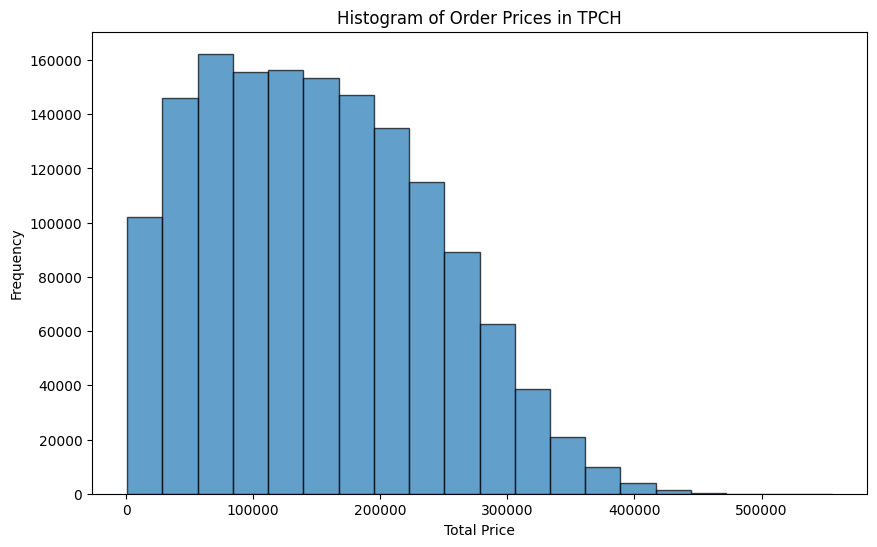

In [39]:
import matplotlib.pyplot as plt

df= result.df

plt.figure(figsize=(10, 6))
plt.hist(df["order_price"], bins=20, edgecolor="black", alpha=0.7)

# Configurar etiquetas y título
plt.xlabel("Total Price")
plt.ylabel("Frequency")
plt.title("Histogram of Order Prices in TPCH")

# Mostrar el gráfico
plt.show()

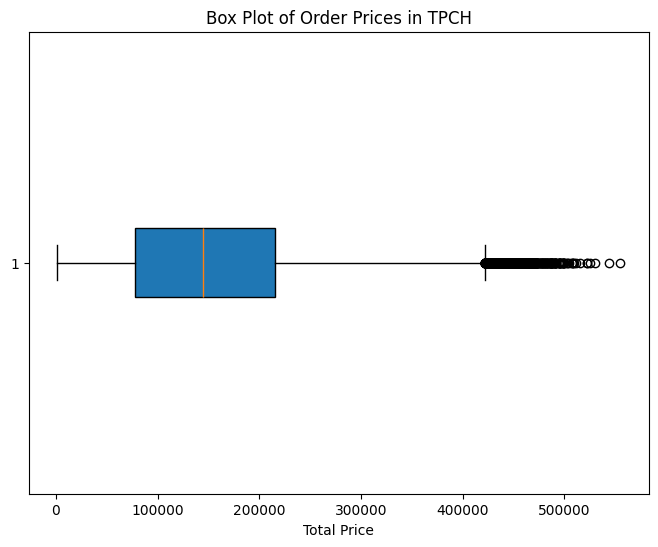

In [37]:
# Create a box plot for order prices
plt.figure(figsize=(8, 6))
plt.boxplot(df["order_price"], vert=False, patch_artist=True)

# Configure labels and title
plt.xlabel("Total Price")
plt.title("Box Plot of Order Prices in TPCH")

# Show the plot
plt.show()

---
## Query Quality and Verification

In the future we will be able to take the PyDough code, the user question, the knowledge graph and the generated data frame to perform semantic tests that will help assure the quality of the results. Some ideas that are under evaluation: 

1. John's graph reconstruction / deconstruction / verification ideas
2. LLM based rules that allow us to confirm certain properties of the Data Frame
   a. If the user requires a top 5 result, then the resulting DF must have 5 rows.
3. Program slicing ideas:
   b. If each cell can be traced to a transformation, look at the transformation and match it against the query (this is connected to John's ideas)
4. Emsemble ideas many variations prompts and LLMs could help us compare multiple results.
5. Talk about why Greg is flabbergasted. 

Here we show a simple demonstration of taking the resulting PyDough code, and then generating structured data from it so that you can compare the variables it used, against the original variables in our Knowledge Graph.

In [1]:
import ast
import json
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

class DSLGraphBuilder:
    class VariableNameExtractor(ast.NodeVisitor):
        def __init__(self):
            self.names = set()
        def visit_Name(self, node):
            # Ignore uppercase identifiers (like COUNT or YEAR)
            if not node.id.isupper():
                self.names.add(node.id)
            self.generic_visit(node)
    
    @staticmethod
    def extract_calculate_rhs_names(code):
        """
        Parse a DSL snippet and extract variable names from the right-hand side 
        of CALCULATE keyword assignments.
        """
        tree = ast.parse(code)
        names = set()
        for node in ast.walk(tree):
            if (
                isinstance(node, ast.Call)
                and isinstance(node.func, ast.Attribute)
                and node.func.attr == "CALCULATE"
            ):
                for kw in node.keywords:
                    extractor = DSLGraphBuilder.VariableNameExtractor()
                    extractor.visit(kw.value)
                    names.update(extractor.names)
        return names
    
    @classmethod
    def build_graph_from_snippets(cls, snippets):
        """
        Build a co-occurrence graph where each variable (from CALCULATE calls) 
        is a node, and an edge connects any two variables that appear together in a snippet.
        """
        all_nodes = set()
        snippet_vars = []  # list of sets of variable names per snippet
        for code in snippets:
            vars_in_snippet = cls.extract_calculate_rhs_names(code)
            snippet_vars.append(vars_in_snippet)
            all_nodes.update(vars_in_snippet)
        
        nodes = [{"id": var, "label": var} for var in sorted(all_nodes)]
        edges = []
        added_edges = set()
        for vars_in_snippet in snippet_vars:
            for a, b in combinations(sorted(vars_in_snippet), 2):
                key = tuple(sorted((a, b)))
                if key not in added_edges:
                    added_edges.add(key)
                    edges.append({"source": key[0], "target": key[1]})
        return {"nodes": nodes, "edges": edges}
    
    @staticmethod
    def visualize_graph(graph):
        """
        Visualize the graph using NetworkX and Matplotlib.
        """
        G = nx.Graph()
        for node in graph["nodes"]:
            G.add_node(node["id"])
        for edge in graph["edges"]:
            G.add_edge(edge["source"], edge["target"])
        
        # Use spring layout for a visually appealing graph
        pos = nx.spring_layout(G)
        
        plt.figure(figsize=(8, 6))
        nx.draw_networkx_nodes(G, pos, node_size=500, node_color="lightblue", edgecolors="black")
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_labels(G, pos, font_size=10)
        
        plt.title("Co-occurrence Graph of Variables", fontsize=14)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

Now, this can be used to analyse the PyDough code that was first generated.

{
    "nodes": [
        {
            "id": "acctbal",
            "label": "acctbal"
        },
        {
            "id": "name",
            "label": "name"
        },
        {
            "id": "order_date",
            "label": "order_date"
        },
        {
            "id": "orders",
            "label": "orders"
        }
    ],
    "edges": [
        {
            "source": "acctbal",
            "target": "name"
        },
        {
            "source": "acctbal",
            "target": "order_date"
        },
        {
            "source": "acctbal",
            "target": "orders"
        },
        {
            "source": "name",
            "target": "order_date"
        },
        {
            "source": "name",
            "target": "orders"
        },
        {
            "source": "order_date",
            "target": "orders"
        }
    ]
}


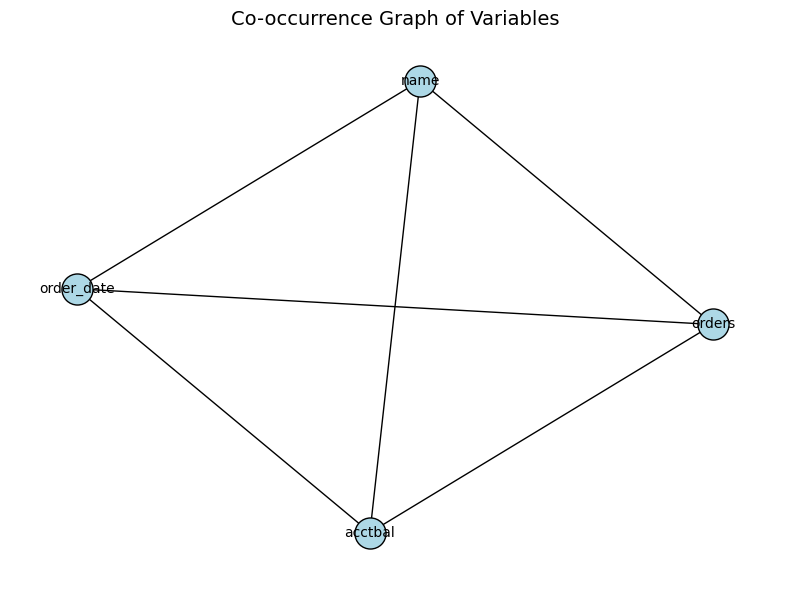

In [2]:
# Using the DSLGraphBuilder defined in a previous cell
builder = DSLGraphBuilder()

# Define your DSL code snippets to analyse

snippet1 = '''# Find all suppliers from the United States
us_suppliers = suppliers.WHERE(nation.name == "UNITED STATES").CALCULATE(
    supplier_name=name
)
'''
snippet2 = '''# Identify orders in 1995
orders_1995 = orders.WHERE(YEAR(order_date) == 1995)
european_customers = customers.CALCULATE(
    customer_name=name,
    account_balance=acctbal,
    num_orders_1995=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE(
    (nation.region.name == "EUROPE") &
    (acctbal > 700) &
    (num_orders_1995 > 0)
)
'''

snippets = [snippet1, snippet2]

# Build the graph structure from your snippets
graph = builder.build_graph_from_snippets(snippets)

# Print out the graph JSON structure if desired
import json
print(json.dumps(graph, indent=4))

# Visualize the graph using matplotlib and networkx
builder.visualize_graph(graph)


---
That generates a graphical view of the variables, and the co-occurence, and a json with that information, which can be compared against the original json knowledge graph for verification.

NB: This is only a first exploratory step, but as we have better ideas on verification, we will be able to add and extend this segment. Which is why it's an entire workstream as planned in our roadmap.

Now, on to more test cases!

---

## Test Cases

Let's now look at a few more test cases and see how PyDough and PyDough LLM does.

### Customer Segmentation

### 1. Find the names of all customers and the number of orders placed in 1995 in Europe.

- Demonstrates simple filtering, counting, and sorting while being business-relevant for regional market analysis. 
- Adds a second filtering layer by including account balance and order activity, making it more dynamic.

In [26]:
query= "Find the names of all customers and the number of orders placed in 1995 in Europe."

result= client.ask(query)

print(result.full_explanation)
result.df.head()

european_customers_orders_1995 = customers.CALCULATE(
    customer_name=name,
    number_of_orders=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE(nation.region.name == "EUROPE")
```python
european_customers_orders_1995 = customers.CALCULATE(
    customer_name=name,
    number_of_orders=COUNT(orders.WHERE(YEAR(order_date) == 1995))
).WHERE(nation.region.name == "EUROPE")
```

**Explanation:**

1. **`customers.CALCULATE(...)`**: This initiates a `CALCULATE` operation on the `customers` collection to select and derive fields.
2. **`customer_name=name`**: This selects the `name` field from the `customers` collection and names it `customer_name` in the output.
3. **`number_of_orders=COUNT(orders.WHERE(YEAR(order_date) == 1995))`**: This calculates the number of orders placed by each customer in 1995.
    - **`orders`**: Accesses the `orders` sub-collection associated with each customer.
    - **`.WHERE(YEAR(order_date) == 1995)`**: Filters the `orders` sub-collection to include only 

,customer_name,number_of_orders
0,Customer#000000011,1
1,Customer#000000015,0
2,Customer#000000018,0
3,Customer#000000020,3
4,Customer#000000026,2


**Follow up**: Now, give me the ones who have an account balance greater than $700 and placed at least one order in that same year. Sorted in descending order by the number of orders.

In [27]:
result= client.discourse(result, 
"""Now, give me the ones who have an account balance greater than $700 and placed at least one order in that same year. 
Sorted in descending order by the number of orders.""")

print(result.full_explanation)
result.df.head()

european_customers_orders_1995_refined = customers.CALCULATE(
    customer_name=name,
    number_of_orders=COUNT(orders.WHERE(YEAR(order_date) == 1995)),
    customer_acctbal=acctbal,
    customer_region_name=nation.region.name
).WHERE(
    (customer_region_name == "EUROPE") &
    (customer_acctbal > 700) &
    (number_of_orders > 0)
).TOP_K(k=999999, by=number_of_orders.DESC())
```python
european_customers_orders_1995_refined = customers.CALCULATE(
    customer_name=name,
    number_of_orders=COUNT(orders.WHERE(YEAR(order_date) == 1995)),
    customer_acctbal=acctbal,
    customer_region_name=nation.region.name
).WHERE(
    (customer_region_name == "EUROPE") &
    (customer_acctbal > 700) &
    (number_of_orders > 0)
).TOP_K(k=999999, by=number_of_orders.DESC())
```

**Explanation:**

1. **`customers.CALCULATE(...)`**:  This initiates a `CALCULATE` operation on the `customers` collection to derive new fields and select existing ones.
    - **`customer_name=name`**: Selects the `name` 

,customer_name,number_of_orders,customer_acctbal,customer_region_name
0,Customer#000107440,12,2464.61,EUROPE
1,Customer#000014920,11,7026.03,EUROPE
2,Customer#000079606,11,989.51,EUROPE
3,Customer#000108496,11,7388.38,EUROPE
4,Customer#000009019,10,2247.06,EUROPE


### 2. List customers who ordered in 1996 but not in 1997, with a total spent of over 1000$?

- Showcases PyDough’s HAS() and HASNOT() functions, helping analyze customer retention and spending patterns. 
- Also incorporates a time-based calculation.

In [51]:
query= "List customers who ordered in 1996 but not in 1997 with a total spent of over 1000$ If you use HAS add a ==1"

result= client.ask(query)

print(result.full_explanation)
result.df.head()

# Find customers who ordered in 1996
customers_1996 = customers.CALCULATE(
    customer_name=name,
    total_spent=SUM(orders.WHERE(YEAR(order_date) == 1996).total_price)
)

# Filter for customers who spent over $1000 in 1996 and had no orders in 1997
result = customers_1996.WHERE(
    (total_spent > 1000) & 
    (HAS(orders.WHERE(YEAR(order_date) == 1996)) == 1) & 
    (HAS(orders.WHERE(YEAR(order_date) == 1997)) == 0)
).CALCULATE(
    customer_name,
    total_spent
)
I'll create a PyDough code snippet to list customers who ordered in 1996 but not in 1997, with a total spent of over $1000.

First, I need to identify customers with orders in 1996, calculate their total spending, and then filter out those who also ordered in 1997.

```python
# Find customers who ordered in 1996
customers_1996 = customers.CALCULATE(
    customer_name=name,
    total_spent=SUM(orders.WHERE(YEAR(order_date) == 1996).total_price)
)

# Filter for customers who spent over $1000 in 1996 and had no orders in 19

,customer_name,total_spent
0,Customer#000000005,98790.79
1,Customer#000000017,481076.02
2,Customer#000000020,538764.56
3,Customer#000000031,720459.29
4,Customer#000000038,788657.01


**Follow up**: Include the number of months since the last order and sort by total spent, highest first.

In [52]:
result= client.discourse(result,
"Now, include the number of months since the last order and sort by total spent, highest first.")

print(result.full_explanation)
result.df.head() 

# Find customers who ordered in 1996
customers_1996 = customers.CALCULATE(
    customer_name=name,
    total_spent=SUM(orders.WHERE(YEAR(order_date) == 1996).total_price),
    last_order_date=MAX(orders.order_date)
)

# Filter for customers who spent over $1000 in 1996 and had no orders in 1997
result = customers_1996.WHERE(
    (total_spent > 1000) & 
    (HAS(orders.WHERE(YEAR(order_date) == 1996)) == 1) & 
    (HAS(orders.WHERE(YEAR(order_date) == 1997)) == 0)
).CALCULATE(
    customer_name,
    total_spent,
    months_since_last_order=DATEDIFF("months", last_order_date, DATETIME("now"))
).ORDER_BY(total_spent.DESC())
I'll modify the previous solution to include the number of months since the last order and sort by total spent in descending order.

```python
# Find customers who ordered in 1996
customers_1996 = customers.CALCULATE(
    customer_name=name,
    total_spent=SUM(orders.WHERE(YEAR(order_date) == 1996).total_price),
    last_order_date=MAX(orders.order_date)
)

# Filter f

,customer_name,total_spent,months_since_last_order
0,Customer#000001948,1785971.27,321
1,Customer#000057892,1668071.25,320
2,Customer#000111028,1626293.12,319
3,Customer#000112711,1623258.35,322
4,Customer#000113131,1597282.31,320


### Sales Performance

### 3. Find the region name with the highest total order value in 1996.

- The total order value is defined as potential revenue, defined as the sum of extended_price * (1 - discount)
- It introduces precise calculations within the query, ensuring revenue insights.

In [53]:
query="""Find the region name with the highest total order value in 1996. 
The total order value is defined as potential revenue, defined as the sum of extended_price * (1 - discount)"""

result= client.ask(query)

print(result.full_explanation)
result.df.head()

# First, filter orders from 1996
orders_1996 = orders.WHERE(YEAR(order_date) == 1996)

# Calculate the total order value for each region
region_order_values = regions.CALCULATE(
    region_name=name,
    total_order_value=SUM(nations.customers.orders_1996.lines.extended_price * (1 - nations.customers.orders_1996.lines.discount))
)

# Find the region with the highest total order value
highest_value_region = region_order_values.TOP_K(1, by=total_order_value.DESC())
# Calculate the total order value for each region in 1996
region_order_values = regions.CALCULATE(
    region_name=name,
    total_order_value=SUM(nations.customers.orders.WHERE(YEAR(order_date) == 1996).lines.extended_price * 
                          (1 - nations.customers.orders.WHERE(YEAR(order_date) == 1996).lines.discount))
)

# Find the region with the highest total order value
highest_value_region = region_order_values.TOP_K(1, by=total_order_value.DESC())
I'll create a PyDough code snippet to find the region name wit

,region_name,total_order_value
0,EUROPE,6.746079e+09


### Product Trends

### 4. Which 10 customers purchased the highest quantity of products during 1998?

Highlights ranking queries (TOP_K()), customer segmentation, and purchasing trends. 

In [54]:
query= "Which 10 customers purchased the highest quantity of products during 1998?"

result= client.ask(query)

print(result.full_explanation)
result.df.head()

# Filter orders to only include those from 1998
orders_1998 = orders.WHERE(YEAR(order_date) == 1998)

# For each customer, calculate the total quantity of products purchased in 1998
customer_quantities = customers.CALCULATE(
    customer_name=name,
    total_quantity=SUM(orders_1998.lines.quantity)
)

# Get the top 10 customers by total quantity purchased
top_10_customers = customer_quantities.TOP_K(10, by=total_quantity.DESC())
I'll create a PyDough code snippet to find the 10 customers who purchased the highest quantity of products during 1998.

```python
# Filter orders to only include those from 1998
orders_1998 = orders.WHERE(YEAR(order_date) == 1998)

# For each customer, calculate the total quantity of products purchased in 1998
customer_quantities = customers.CALCULATE(
    customer_name=name,
    total_quantity=SUM(orders_1998.lines.quantity)
)

# Get the top 10 customers by total quantity purchased
top_10_customers = customer_quantities.TOP_K(10, by=total_quantity.DESC())
```

,customer_name,total_quantity
0,Customer#000119539,1206
1,Customer#000026518,1158
2,Customer#000024877,1104
3,Customer#000000019,1084
4,Customer#000106000,1058


**Follow up**: Now only the ones that have "green" on the product name.

In [55]:
result= client.discourse(result, "Only the ones that have 'green' on the product name.")

print(result.full_explanation)
result.df.head()

# Filter orders to only include those from 1998
orders_1998 = orders.WHERE(YEAR(order_date) == 1998)

# Filter line items to only include those with 'green' in the product name
green_lines = lines.WHERE(CONTAINS(part.name, 'green'))

# For each customer, calculate the total quantity of green products purchased in 1998
customer_quantities = customers.CALCULATE(
    customer_name=name,
    total_quantity=SUM(orders_1998.lines.WHERE(CONTAINS(part.name, 'green')).quantity)
)

# Get the top 10 customers by total quantity of green products purchased
top_10_customers = customer_quantities.TOP_K(10, by=total_quantity.DESC())
I'll modify the previous solution to only include quantities from products that have 'green' in their name. Here's the updated code:

```python
# Filter orders to only include those from 1998
orders_1998 = orders.WHERE(YEAR(order_date) == 1998)

# Filter line items to only include those with 'green' in the product name
green_lines = lines.WHERE(CONTAINS(part.name, 'green')

,customer_name,total_quantity
0,Customer#000011509,208
1,Customer#000022147,201
2,Customer#000027577,201
3,Customer#000109117,176
4,Customer#000016252,172


### Revenue Performance (WIP)

### 5. What is the february 1996 SPM for the almond antique blue royal burnished part in China?

- SPM (Selling Profit Margin) = (Total Amount from Sells - (Tax + Commission)) / Total Amount from Sells * 100
- This query was provided as a representative example of potential stakeholder inquiries.
- Showcases advanced partitioning and filtering, demonstrating how PyDough can be used for highly specific business KPIs. 
- Compare with a previous time period and exclude/include specific suppliers, making it a progressive data exploration example.

In [56]:
query= """What is the february 1996 SPM for the almond antique blue royal burnished part in China? 
SPM (Selling Profit Margin) = (Total Amount from Sells - (Tax + Commission)) / Total Amount from Sells * 100"""

result= client.ask(query)

print(result.full_explanation)
result.df.head()

# Find the specific part and calculate SPM for February 1996 in China
almond_part_spm = lines.WHERE(
    CONTAINS(part.name, "almond antique blue royal burnished") &
    (MONTH(ship_date) == 2) &
    (YEAR(ship_date) == 1996) &
    (supplier.nation.name == "CHINA")
).CALCULATE(
    part_name=part.name,
    total_amount=SUM(extended_price),
    total_tax=SUM(tax * extended_price),
    total_commission=SUM(discount * extended_price),
    spm=((SUM(extended_price) - SUM((tax + discount) * extended_price)) / SUM(extended_price)) * 100
)
I need to create a PyDough query to calculate the February 1996 Selling Profit Margin (SPM) for the "almond antique blue royal burnished" part in China.

First, I'll identify the part by its name, then find all line items for this part that were sold in China during February 1996. Then I'll calculate the SPM using the formula provided.

```python
# Find the specific part and calculate SPM for February 1996 in China
almond_part_spm = lines.WHERE(
    CONTAIN

AttributeError: 'NoneType' object has no attribute 'head'

**Follow up**: Compare that to november 1995 SPM, have we seen an increase?

In [35]:
query+= """Compare that to november 1995 SPM, have we seen an increase?"""

result= client.ask(query)

print(result.full_explanation)
result.df.head()

Let me help break this down into steps to calculate the SPM for the specific part in China for both time periods and compare them.

We need to:
1. Find the specific part (almond antique blue royal burnished)
2. Filter for sales in China
3. Calculate SPM for Feb 1996 and Nov 1995
4. Compare the results

Here's the PyDough code:

```python
# First identify the part and calculate SPM for both months
part_spm = parts.WHERE(
    (name == "almond antique blue royal burnished")
).CALCULATE(
    part_key=key,
    # February 1996 calculations
    feb_96_sales=SUM(
        lines.WHERE(
            (YEAR(order.order_date) == 1996) & 
            (MONTH(order.order_date) == 2) &
            (order.customer.nation.name == "CHINA")
        ).extended_price
    ),
    feb_96_tax=SUM(
        lines.WHERE(
            (YEAR(order.order_date) == 1996) & 
            (MONTH(order.order_date) == 2) &
            (order.customer.nation.name == "CHINA")
        ).tax
    ),
    # November 1995 calculations


AttributeError: 'NoneType' object has no attribute 'head'

**Follow up**: Now exclude supplier Supplier#000001305 and focus only on supplier Supplier#000008802

In [ ]:
result= client.discourse(result, """Now exclude supplier Supplier#000001305 
                         and focus only on supplier Supplier#000008802v""")

print(result.full_explanation)
result.df.head()